In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoModelForSequenceClassification, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('FINAL_data2.csv')
df.drop(columns=['word_count'], inplace=True)
df.rename(columns={'dialect': 'labels'}, inplace=True)

In [ ]:
set(df.labels.values)

In [ ]:
names={'Egyptian':0, 'Iraqi':1, 'Khaleeji':2, 'Levantine':3, 'Lybia':4, 'Maghrebi':5, 'Sudani':6}


In [ ]:
df['labels'] = df['labels'].map(names)
df['labels'] = df['labels'].astype('int')

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['labels'].tolist(),
    test_size=0.1,
    random_state=42,
    stratify=df['labels']
    , shuffle=True
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['labels'].tolist(),
    test_size=0.1,
    random_state=42,
    stratify=df['labels']
    , shuffle=True
)

In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'labels': val_labels})
datasets = DatasetDict({"train": train_dataset, "validation": val_dataset})

In [ ]:
araberttokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERTv2")
model = AutoModelForSequenceClassification.from_pretrained("UBC-NLP/MARBERTv2", num_labels=7)

In [ ]:
lora_config = LoraConfig(
    r=16,                        # Low-rank factor
    lora_alpha=16,              # Scaling
    target_modules=["query","key","value","dense"],
    lora_dropout=0.2,               # Common for BERT attention layers # Regularization
    bias="none",
    task_type=TaskType.SEQ_CLS # For classification
)
peft_model = get_peft_model(model, 
                            lora_config)

In [ ]:
# Tokenize all text entries
tokenized_inputs = araberttokenizer(
    list(train_dataset['text']),    
    padding=True,
    max_length=16,                       
    truncation=False,                     
    return_tensors='pt'                   
)
labels = torch.tensor(train_dataset['labels'])

In [ ]:
tokenized_inputs_val = araberttokenizer(
    list(val_dataset['text']),                   
    padding=True,      
    max_length=16,                  
    truncation=False,                     
    return_tensors='pt'                    
)
labels_val = torch.tensor(val_dataset['labels'])

In [ ]:
from torch.utils.data import Dataset

class BERTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item


In [ ]:
dataset = BERTDataset(tokenized_inputs, labels)
val_dataset = BERTDataset(tokenized_inputs_val, labels_val)

In [28]:
test_dataset = BERTDataset(
    araberttokenizer(
        list(test_texts),                   
        padding=True,      
        max_length=16,                  
        truncation=False,                     
        return_tensors='pt'                    
    ),
    test_labels
)

d:\LLMS\.venv\lib\site-packages\transformers\tokenization_utils_base.py:2364: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [ ]:
peft_model = get_peft_model(model, 
                            lora_config)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.tensor(logits).argmax(dim=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
    }

In [ ]:
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2
)

In [ ]:
peft_training_args = TrainingArguments(
    output_dir="./Forth_trial/model",
    auto_find_batch_size=True,
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=50,
    fp16=True  
)
    
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [24]:
peft_trainer.train()

 94%|█████████▍| 26701/28332 [1:13:19<03:28,  7.83it/s]

{'loss': 0.5048, 'learning_rate': 2.8995482140336017e-05, 'epoch': 3.77}


 94%|█████████▍| 26751/28332 [1:13:24<02:48,  9.36it/s]

{'loss': 0.4555, 'learning_rate': 2.8113087674714107e-05, 'epoch': 3.78}


 95%|█████████▍| 26800/28332 [1:13:30<03:31,  7.23it/s]

{'loss': 0.4677, 'learning_rate': 2.723069320909219e-05, 'epoch': 3.78}


 95%|█████████▍| 26850/28332 [1:13:45<08:09,  3.03it/s]

{'loss': 0.4799, 'learning_rate': 2.6348298743470282e-05, 'epoch': 3.79}


 95%|█████████▍| 26900/28332 [1:13:58<06:45,  3.53it/s]

{'loss': 0.5374, 'learning_rate': 2.548355216716081e-05, 'epoch': 3.8}


 95%|█████████▌| 26950/28332 [1:14:12<06:44,  3.42it/s]

{'loss': 0.5169, 'learning_rate': 2.4601157701538894e-05, 'epoch': 3.8}


 95%|█████████▌| 27000/28332 [1:14:26<06:09,  3.60it/s]

{'loss': 0.5139, 'learning_rate': 2.3718763235916985e-05, 'epoch': 3.81}


 95%|█████████▌| 27050/28332 [1:14:39<05:13,  4.08it/s]

{'loss': 0.4984, 'learning_rate': 2.2836368770295075e-05, 'epoch': 3.82}


 96%|█████████▌| 27100/28332 [1:14:53<05:12,  3.94it/s]

{'loss': 0.4526, 'learning_rate': 2.1953974304673163e-05, 'epoch': 3.83}


 96%|█████████▌| 27150/28332 [1:15:06<05:49,  3.39it/s]

{'loss': 0.4936, 'learning_rate': 2.107157983905125e-05, 'epoch': 3.83}


 96%|█████████▌| 27200/28332 [1:15:21<05:33,  3.39it/s]

{'loss': 0.4115, 'learning_rate': 2.0189185373429337e-05, 'epoch': 3.84}


 96%|█████████▌| 27250/28332 [1:15:38<07:00,  2.57it/s]

{'loss': 0.4226, 'learning_rate': 1.9306790907807428e-05, 'epoch': 3.85}


 96%|█████████▋| 27300/28332 [1:15:55<05:22,  3.20it/s]

{'loss': 0.4837, 'learning_rate': 1.8424396442185512e-05, 'epoch': 3.85}


 97%|█████████▋| 27350/28332 [1:16:15<07:24,  2.21it/s]

{'loss': 0.4476, 'learning_rate': 1.7542001976563602e-05, 'epoch': 3.86}


 97%|█████████▋| 27400/28332 [1:16:36<06:03,  2.56it/s]

{'loss': 0.4667, 'learning_rate': 1.6659607510941693e-05, 'epoch': 3.87}


 97%|█████████▋| 27450/28332 [1:16:55<05:44,  2.56it/s]

{'loss': 0.4266, 'learning_rate': 1.577721304531978e-05, 'epoch': 3.88}


 97%|█████████▋| 27500/28332 [1:17:12<05:21,  2.59it/s]

{'loss': 0.4612, 'learning_rate': 1.489481857969787e-05, 'epoch': 3.88}


 97%|█████████▋| 27551/28332 [1:17:25<01:24,  9.24it/s]

{'loss': 0.4193, 'learning_rate': 1.4012424114075957e-05, 'epoch': 3.89}


 97%|█████████▋| 27600/28332 [1:17:31<03:27,  3.53it/s]

{'loss': 0.4735, 'learning_rate': 1.3130029648454046e-05, 'epoch': 3.9}


 98%|█████████▊| 27650/28332 [1:17:45<03:10,  3.58it/s]

{'loss': 0.4545, 'learning_rate': 1.2247635182832133e-05, 'epoch': 3.9}


 98%|█████████▊| 27700/28332 [1:17:59<03:07,  3.37it/s]

{'loss': 0.4931, 'learning_rate': 1.1365240717210222e-05, 'epoch': 3.91}


 98%|█████████▊| 27750/28332 [1:18:13<02:45,  3.53it/s]

{'loss': 0.5503, 'learning_rate': 1.048284625158831e-05, 'epoch': 3.92}


 98%|█████████▊| 27801/28332 [1:18:27<02:20,  3.78it/s]

{'loss': 0.3909, 'learning_rate': 9.6004517859664e-06, 'epoch': 3.92}


 98%|█████████▊| 27850/28332 [1:18:40<02:07,  3.78it/s]

{'loss': 0.5114, 'learning_rate': 8.718057320344487e-06, 'epoch': 3.93}


 98%|█████████▊| 27900/28332 [1:18:53<01:52,  3.83it/s]

{'loss': 0.4028, 'learning_rate': 7.835662854722576e-06, 'epoch': 3.94}


 99%|█████████▊| 27950/28332 [1:19:07<01:51,  3.42it/s]

{'loss': 0.4616, 'learning_rate': 6.9532683891006635e-06, 'epoch': 3.95}


 99%|█████████▉| 28000/28332 [1:19:22<01:34,  3.53it/s]

{'loss': 0.5568, 'learning_rate': 6.070873923478752e-06, 'epoch': 3.95}


 99%|█████████▉| 28050/28332 [1:19:36<01:07,  4.17it/s]

{'loss': 0.4149, 'learning_rate': 5.188479457856841e-06, 'epoch': 3.96}


 99%|█████████▉| 28100/28332 [1:19:50<01:14,  3.13it/s]

{'loss': 0.4226, 'learning_rate': 4.306084992234929e-06, 'epoch': 3.97}


 99%|█████████▉| 28150/28332 [1:20:05<00:49,  3.71it/s]

{'loss': 0.4241, 'learning_rate': 3.4236905266130173e-06, 'epoch': 3.97}


100%|█████████▉| 28200/28332 [1:20:20<00:41,  3.18it/s]

{'loss': 0.4381, 'learning_rate': 2.5412960609911054e-06, 'epoch': 3.98}


100%|█████████▉| 28250/28332 [1:20:36<00:26,  3.13it/s]

{'loss': 0.4353, 'learning_rate': 1.6589015953691938e-06, 'epoch': 3.99}


100%|█████████▉| 28300/28332 [1:20:52<00:10,  2.96it/s]

{'loss': 0.5333, 'learning_rate': 7.765071297472822e-07, 'epoch': 4.0}


                                                       
100%|██████████| 28332/28332 [1:22:07<00:00,  3.46it/s]

{'eval_loss': 0.6814919114112854, 'eval_accuracy': 0.7920273167632812, 'eval_runtime': 65.4518, 'eval_samples_per_second': 192.401, 'eval_steps_per_second': 12.039, 'epoch': 4.0}


100%|██████████| 28332/28332 [1:22:09<00:00,  5.75it/s]

{'train_runtime': 4929.3666, 'train_samples_per_second': 91.962, 'train_steps_per_second': 5.748, 'train_loss': 0.6376093878982331, 'epoch': 4.0}


TrainOutput(global_step=28332, training_loss=0.6376093878982331, metrics={'train_runtime': 4929.3666, 'train_samples_per_second': 91.962, 'train_steps_per_second': 5.748, 'train_loss': 0.6376093878982331, 'epoch': 4.0})

In [25]:
model.save_pretrained("final_model")

In [26]:
peft_model.save_pretrained("final_model")
araberttokenizer.save_pretrained("final_model")

('final_model\\tokenizer_config.json',
 'final_model\\special_tokens_map.json',
 'final_model\\vocab.txt',
 'final_model\\added_tokens.json',
 'final_model\\tokenizer.json')

In [27]:
input_text = """
يزول شغال انت ولا لا 
"""
inputs = araberttokenizer(
    input_text,
    return_tensors="pt",
    padding=True,
    max_length=20,
    truncation=True,
)
inputs = inputs.to(peft_model.device)
with torch.no_grad():
    outputs = peft_model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
names2 = {v: k for k, v in names.items()}
predicted_label = names2[predictions.item()]
print(f"Predicted dialect: {predicted_label}")

Predicted dialect: Sudani


# Model Analysis

In [ ]:
p = peft_trainer.predict(test_dataset)
predicted_test = torch.tensor(p.predictions).argmax(dim=-1)

d:\LLMS\.venv\lib\site-packages\transformers\trainer.py:2610: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
100%|██████████| 788/788 [00:25<00:00, 30.34it/s]


In [32]:
p = peft_trainer.predict(dataset)
predicted_train = torch.tensor(p.predictions).argmax(dim=-1)

d:\LLMS\.venv\lib\site-packages\transformers\trainer.py:2610: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
100%|██████████| 7083/7083 [06:44<00:00, 17.51it/s]


In [35]:
predictions_test_df = pd.DataFrame({
    'true_labels': test_labels, 
    'predicted_labels': predicted_test.tolist() 
})

predictions_train_df = pd.DataFrame({
    'true_labels': train_labels,         
    'predicted_labels': predicted_train.tolist()     
})

In [36]:
# acc 
accuracy = accuracy_score(predictions_test_df['true_labels'], predictions_test_df['predicted_labels'])
print(f"Validation Accuracy: {accuracy:.4f}")
accuracy = accuracy_score(predictions_train_df['true_labels'], predictions_train_df['predicted_labels'])
print(f"Training Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7920
Training Accuracy: 0.8927


In [37]:
predictions_test_df.to_csv('Final_predictions_test_df.csv', index=False)
predictions_train_df.to_csv('Final_predictions_train_df.csv', index=False)

In [38]:
predictions_train_df['text'] = train_texts
predictions_test_df['text'] = val_texts
predictions_test_df['word_count'] = predictions_test_df['text'].apply(lambda x: len(x.split()))
predictions_train_df['word_count'] = predictions_train_df['text'].apply(lambda x: len(x.split()))

In [39]:
incorrect = predictions_test_df[predictions_test_df.true_labels != predictions_test_df.predicted_labels]
incorrect

,true_labels,predicted_labels,text,word_count
5,3,1,بمصحات علاجيه مو يبلونا بمناظرهم المقزه,6
7,4,5,الخال الورشفاني مديريه امن جفاره المدعو ناصر ا...,14
8,6,1,ابل الضحك تقولي شنو جلابه وشريت نيلي وحقنا ماكول,9
21,1,2,نتفق وقت الخاص ويصير خير,5
26,6,0,كده غريب يتعلق بالحيوانات والاسماك,5
...,...,...,...,...
12569,1,4,خفوا التشريب منين تجيكم لياقه شهالكروش,6
12574,3,6,بالعكس برضو نومه الارض حلوه,5
12583,2,1,غاب وغاب الفوز اختصار الموسم وهذا موعذر ابدا ش...,12
12590,3,2,الاوروبين وليش ضربوهم جزيره ليروس يومين,6


<Axes: >

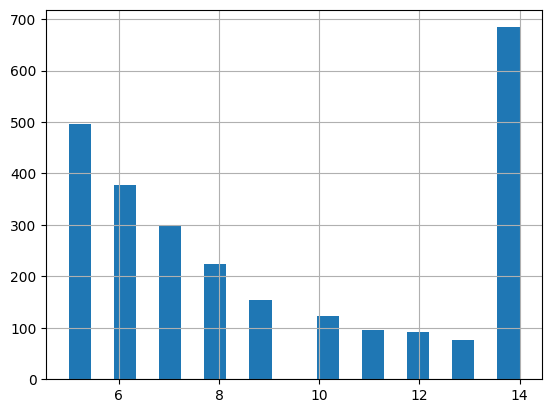

In [ ]:
incorrect.word_count.hist(bins=20)

In [46]:
d = predictions_test_df.value_counts('word_count')
for key, value in incorrect.word_count.value_counts().items():
    print(f"WordCount: {key}, % of WordCount: {d[key]/30600*100:.2f}%, % of error in this WordCount: {value/d[key]*100:.2f}%")
    


WordCount: 14, % of WordCount: 14.21%, % of error in this WordCount: 15.73%
WordCount: 5, % of WordCount: 5.43%, % of error in this WordCount: 29.84%
WordCount: 6, % of WordCount: 4.52%, % of error in this WordCount: 27.24%
WordCount: 7, % of WordCount: 3.70%, % of error in this WordCount: 26.21%
WordCount: 8, % of WordCount: 3.37%, % of error in this WordCount: 21.73%
WordCount: 9, % of WordCount: 2.58%, % of error in this WordCount: 19.62%
WordCount: 10, % of WordCount: 2.19%, % of error in this WordCount: 18.18%
WordCount: 11, % of WordCount: 2.01%, % of error in this WordCount: 15.42%
WordCount: 12, % of WordCount: 1.65%, % of error in this WordCount: 18.18%
WordCount: 13, % of WordCount: 1.48%, % of error in this WordCount: 17.00%


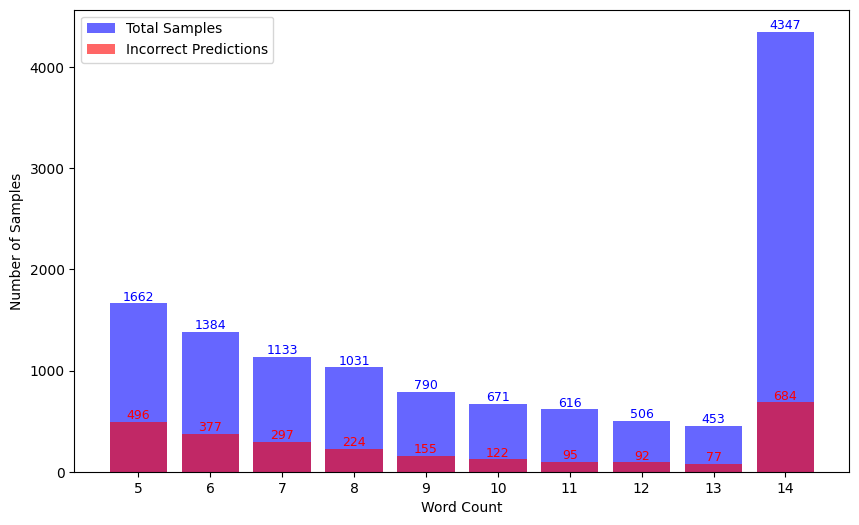

In [51]:
plt.figure(figsize=(10, 6))
total_counts = [d.get(wc, 0) for wc in word_counts]
incorrect_counts = [incorrect.word_count.value_counts().get(wc, 0) for wc in word_counts]

bars1 = plt.bar(word_counts, total_counts, color='blue', alpha=0.6, label='Total Samples')
bars2 = plt.bar(word_counts, incorrect_counts, color='red', alpha=0.6, label='Incorrect Predictions')

for bar, count in zip(bars1, total_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9, color='blue')
for bar, count in zip(bars2, incorrect_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count, str(count), ha='center', va='bottom', fontsize=9, color='red')

plt.xlabel('Word Count')
plt.ylabel('Number of Samples')
plt.xticks(word_counts)
plt.legend()
plt.show()


In [42]:
from sklearn.metrics import classification_report

report = classification_report(predictions_test_df['true_labels'], predictions_test_df['predicted_labels'], target_names=names2.values())
print(report)

              precision    recall  f1-score   support

    Egyptian       0.78      0.86      0.82      1800
       Iraqi       0.80      0.78      0.79      1799
    Khaleeji       0.69      0.76      0.72      1797
   Levantine       0.80      0.79      0.80      1799
       Lybia       0.78      0.77      0.78      1800
    Maghrebi       0.84      0.78      0.81      1798
      Sudani       0.86      0.80      0.83      1800

    accuracy                           0.79     12593
   macro avg       0.79      0.79      0.79     12593
weighted avg       0.79      0.79      0.79     12593



In [ ]:
accuracies = []
for i in range(0,7):
    l_pred_true = predictions_test_df[(predictions_test_df['predicted_labels'] == i) & (predictions_test_df['true_labels'] == i)]
    accuracies.append(len(l_pred_true) / len(predictions_test_df[predictions_test_df['predicted_labels'] == i]))
for i,acc in enumerate(accuracies):
    print(f"Accuracy for {names2[i]}: {acc:.4f}")

Accuracy for Egyptian: 0.7819
Accuracy for Iraqi: 0.8027
Accuracy for Khaleeji: 0.6936
Accuracy for Levantine: 0.7999
Accuracy for Lybia: 0.7803
Accuracy for Maghrebi: 0.8403
Accuracy for Sudani: 0.8649


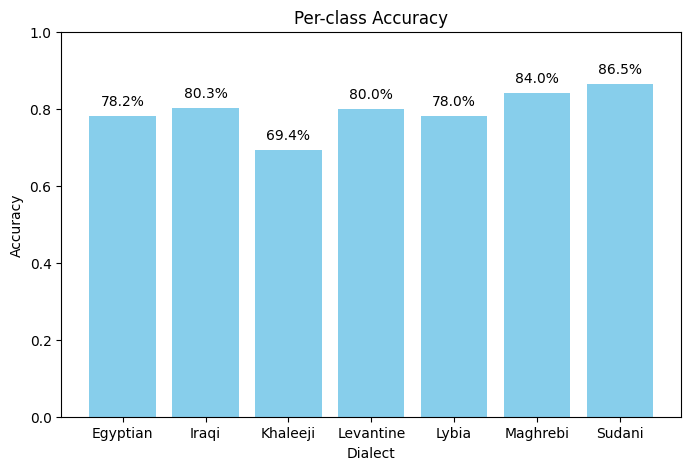

In [54]:
plt.figure(figsize=(8, 5))
plt.bar(list(names2.values()), accuracies, color='skyblue')
plt.ylabel('Accuracy')
plt.xlabel('Dialect')
plt.ylim(0, 1)
plt.title('Per-class Accuracy')

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc*100:.1f}%", ha='center', va='bottom', fontsize=10, color='black')

plt.show()


<Axes: >

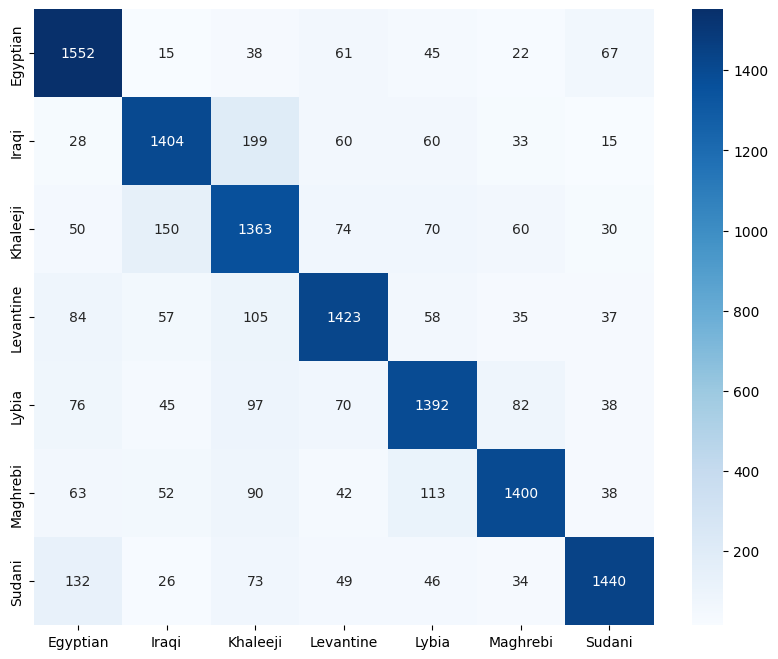

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(predictions_test_df['true_labels'], predictions_test_df['predicted_labels'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=names2.values(), yticklabels=names2.values())